# Scraping bullshit jobs ... a long way to hell

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


# library for plotting data over maps
import shapefile as shp

# libraries used for tokenization
from itertools import chain
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize, MWETokenizer

# Libraries used to remove similar job description based on cosine similarity 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# libraries used for text normalization
import string
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist


# use to get USdollar / euro exchange rate from exchange rate API
import requests

from unidecode import unidecode

# import my functions
from preprocessing import preprocess as pp

#nltk.download('punkt')
#nltk.download('stopwords')

## Load data

In [105]:
df = pd.read_csv('/home/axel/ds_projects/projects/gg_job_search/data/gg_job_search_all_RAW.csv')
data = df.copy()

## General overview

In [106]:
print(data.info(), '\n')
print(data.nunique(), '\n')
print(data.search_query.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19423 entries, 0 to 19422
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      19423 non-null  int64  
 1   title           19423 non-null  object 
 2   company_name    19423 non-null  object 
 3   location        19412 non-null  object 
 4   via             19423 non-null  object 
 5   description     19363 non-null  object 
 6   job_highlights  13090 non-null  object 
 7   related_links   19363 non-null  object 
 8   thumbnail       17657 non-null  object 
 9   extensions      19423 non-null  object 
 10  job_id          16609 non-null  object 
 11  posted_at       17430 non-null  object 
 12  schedule_type   19256 non-null  object 
 13  date_time       19423 non-null  object 
 14  search_query    19423 non-null  object 
 15  Unnamed: 0.1    6333 non-null   float64
dtypes: float64(1), int64(1), object(14)
memory usage: 2.4+ MB
None 

Unnamed: 0 

## Null values 

In [107]:
data.isnull().sum()[data.isnull().sum() > 0]

location             11
description          60
job_highlights     6333
related_links        60
thumbnail          1766
job_id             2814
posted_at          1993
schedule_type       167
Unnamed: 0.1      13090
dtype: int64

## Duplicates

In [109]:
print('Number of duplicates :',data[data.duplicated()].shape[0])
print('Number of duplicates (based on identical job_id) :', data[data.duplicated(['job_id'])].shape[0],'\n', '='*70) 

# removing duplicates based on job_id
data = data.drop_duplicates(['job_id'])
data.reset_index(inplace=True)

print('Search query results :\n', data.search_query.value_counts(), '\n', '='*70)
print('Final number of rows : ', data.shape[0])
print('Final number of columns : ', data.shape[1])

Number of duplicates : 546
Number of duplicates (based on identical job_id) : 16483 
Search query results :
 data scientist    1605
data analyst       720
data engineer      615
Name: search_query, dtype: int64 
Final number of rows :  2940
Final number of columns :  17


#### INSIGHTS :

Purely based job id, we can skim off a lots of duplicates. Nonetheless i still found a few of identical / near-identical job descriptions, maybe because [sometimes recruiters or companies post the same advert for a job which results in duplicate data.](https://medium.com/analytics-vidhya/data-science-job-search-using-nlp-and-lda-in-python-12ecbfac79f9)

To get rid off these ones, i could use cosine similatity between job descriptions.

In [110]:
### removing duplicates based on cosine similarity between 
## job descriptions (code from Thomas Caffrey, see link above)

# Defining our collection of job description texts to tokenize
data.description = data['description'].fillna('')
corpus = data['description']

# instantiate CountVectorizer object
count_vect = CountVectorizer()

# Fit_transform to vectorize each job description (map terms to feature indices)
X_train_counts = count_vect.fit_transform(corpus)

# Compute cosine similarities and put it in dataframe
cos_df = pd.DataFrame(cosine_similarity(X_train_counts))


## reshape dataframe for easier comparison

# get arrays of rows indices and col indices from col_df.shape
i, j = np.indices(cos_df.shape).reshape(2,-1)

# reshape values to get a 1D array 
cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'sim':cos_values})

# get cosine similarity values only above 0.98 
cos_rem = cos_sim_df[(cos_sim_df['sim'] > 0.98) & (i!=j)]

# Method to remove duplicates but keep first instance:
# Trying to drop duplicates on i and j columns won't work as the row numbers of duplicates are either in i or j not both.
# Setting another column that combines the i & j values ensures that duplicates can be dropped.

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates('i*j')['i'].values)

# keep only non-duplicated job postings
data = data[~data.index.isin(drop_rows)] 
data.reset_index(inplace=True)

print('Number of duplicates (based on cosine similarity) : ' ,drop_rows.shape[0])
print('Final number of rows : ', data.shape[0])
print('Final number of columns : ', data.shape[1])

Number of duplicates (based on cosine similarity) :  1108
Final number of rows :  1832
Final number of columns :  18


/tmp/ipykernel_33441/1214297801.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


## Extensions

In [111]:
data.extensions

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ['il y a 17 heures', 'À plein temps']

## Title 

In [112]:
#list(data.title.values)

#### INSIGHTS :

Based on this sample of job titles, we could create : 
    
    * Contract_type (full-time, part-time ...) 
    * Contract_status (CDI, CDD, work-study, internship ...)
    * Duration of Contract (Duration/Undetermined)
    * Experience ( Senior, Junior ...)
    * Data Specialization (Supply chain, Marketing, Clinical ...)
    * Multiple titles (Analyst/Scientist, Scientist/ML Engineer, Manager/Analyst ...)
    * Specific expertise asked for (Python, Power BI ...)
    
    

## Explore company_name

In [113]:
print('number of unique companies :', data.company_name.nunique())
#data.company_name.unique()

number of unique companies : 1105


In [114]:
pd.options.display.max_colwidth = 20
#data.loc[data['company_name'] == 'Unspecified', ['description']].iloc[0]

#### INSIGHTS :

When ***Unspecified***, companies name can be found in description column.

Possible new columns :

    * Group/Holding (Y/N/NC)
    * Interim company (Y/N/NC)

Based on the number of job posting per company we could potentially infer about : **size of company ? / Amount of data to work on** / 

Adding a time variable and much more data, the number of similar / identical job postings for the same company could maybe give insights on the **company's turnover rate / company's growth / magnitude of need-urgency to hire** ...  

It seems like extracting additional informations without more context will be difficult. Having access to each company's structure information we could create :

    * Size of company
    * Industry
    * Public / Private
    
We'll see if can extract more related informations in the following columns. Otherwise, we could try to scrap **Glassdoor databases** (or similar) to get those informations.remains to be seen ...

## Explore location

In [115]:
print('number of unique locations : ', data.location.nunique())
#data.location.unique()

number of unique locations :  256


In [116]:
pd.options.display.max_rows = 50
#data.location.value_counts().head(20)

#### INSIGHTS :

We could create a map of th repartition of job posting based on location provided.

Some companies don't provide precise location *(ex : location = FRANCE)* and the information is not available in description column either. Further investigations will be needed for these companies, perhaps in conjunction with other databases *(GLASSDOOR / SIRENE databases for instance)*.

## Explore via

In [117]:
print('number of unique job plateforms : ', data.via.nunique())
# data.via.unique()

number of unique job plateforms :  111


## Explore description

count     1832.000000
mean      2943.989629
std       1643.546334
min          0.000000
25%       1776.750000
50%       2678.500000
75%       3857.250000
max      14170.000000
Name: description, dtype: float64


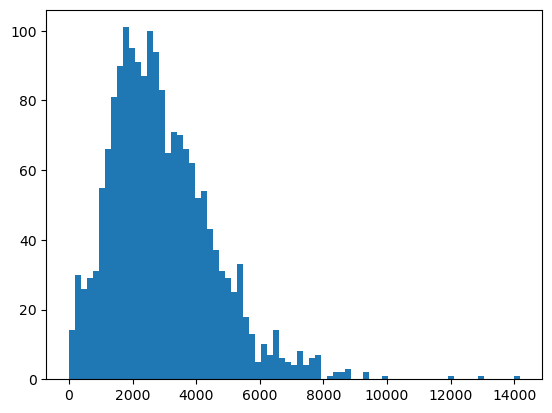

In [118]:
print(data.description.str.len().describe())

plt.hist(data.description.str.len(), bins=75)
plt.show()

#### INSIGHTS :


We could create :

    * Lenght of description (dunno what informations it could provide yet)
    * Toold required (Excel, Google Tag Manager ...)
    * Coding languages required (R, Python, SQL ...)
    * Skills required (reporting, data visualization)
    * Required experience
    * Duration of contract
    * Avantages (ticket resto)


In [119]:
def create_employment_type(row):
    employment_type_dict = {
        'CDI': ['cdi',],
        'internship': ['stage', 'internship', 'stagiaire'],
        'apprenticeship': ['alternant', '(apprenti)', 'professionnalisation', 'alternance'],
        'CDD': ['cdd'],
        'freelance': ['freelance', 'prestataire', 'freelancer'],
        'interim': ['interim'],
        'consultant': ['consultant'],
    }
    for employment_type, keywords in employment_type_dict.items():
        for keyword in keywords:
            if re.search(keyword, unidecode(row['title']), re.I|re.U) or re.search(keyword, unidecode(row['description']), re.IGNORECASE):
                return employment_type
    return np.NaN

def create_seniority_level(row):
    seniority_level_dict = {
        'senior': ['senior', 'advanced', 'avance', 'sr', 'experimente'],
        'mid-level': ['confirme'],
        'junior': ['junior', 'debutant', 'jr', 'entre-level'],
    }
    for seniority_level, keywords in seniority_level_dict.items():
        for keyword in keywords:
            if re.search(keyword, unidecode(row['title']), re.I|re.U): #or re.search(keyword, unidecode(row['description']), re.IGNORECASE):
                return seniority_level
    return np.NaN

def create_executive_title(row):
    executive_title_dict = {
        'lead': ['lead'],
        'Director': ['director', 'directeur'],
        'Manager': ['manager', 'project manager', 'chef de projet'],
        'Assistant': ['assistant'],
        'Chief': ['chief'],
        'Head': ['head'],
        'Supervisor': ['supervisor'],
    }
    for executive_title, keywords in executive_title_dict.items():
        for keyword in keywords:
            if re.search(keyword, unidecode(row['title']), re.I|re.U):
                return executive_title
    return np.NaN

def create_job_specialization(row):
    job_specialization_dict = {
        'career': ['career'],
        'web': ['web'],
        'media': ['media'],
        'online': ['online'],
        'marketing': ['marketing', 'market'],
        'crm': ['crm'],
        'assurance': ['indemnisation'],
        'immobilier': ['immobilier'],
        'product': ['product'],
        'people': ['people', 'hr', 'human', 'workforce'],
        'informatique': ['informatique'],
        'supply_chain': ['supply'],
        'logistique': ['logistique'],
        'medical': ['medical', 'clinique', 'sante'],
        'finance': ['finance'],
        'recherche': ['recherche'],
        'tv': ['tv'],
        'game': ['game'],
        'geo': ['geo'],
    }
    for job_specialization, keywords in job_specialization_dict.items():
        for keyword in keywords:
            if re.search(keyword,unidecode(row['title']), re.I|re.U):
                return job_specialization
    return np.NaN

def create_remote(row):
    remote_dict = {
        'Y': ['remote', 'teletravail hybride', 'teletravail complet', 'jour de teletravail',
                   'jours de teletravail', 'teletravail partiel', 'distanciel', 'teletravail', '(TT)']        
    }
    for remote, keywords in remote_dict.items():
        for keyword in keywords:
            if re.search(keyword, unidecode(row['title']), re.I|re.U) or re.search(keyword, unidecode(row['description']), re.IGNORECASE):
                return remote
    return np.NaN

def create_full_partial_remote(row):
    full_partial_remote_dict = {
        'full': ['full remote', 'teletravail complet'],
        'partial_remote': ['teletravail de','teletravail hybride', 'jours de teletravail', 'teletravail partiel', 'jour de teletravail',]
    }
    for remote, keywords in full_partial_remote_dict.items():
        for keyword in keywords:
            if re.search(keyword, unidecode(row['title']), re.I|re.U) or re.search(keyword, unidecode(row['description']), re.IGNORECASE):
                return remote
    return np.NaN



#data = data.applymap(lambda x: unidecode(x) if isinstance(x, str) else x) # used for accent-insensitive search, got replaced directly in functions (see above)
# lower every string of dataframe for easier search
data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

data['executive_title'] = data.apply(create_executive_title, axis=1)
data['seniority_level'] = data.apply(create_seniority_level, axis=1) 
data['employment_type'] = data.apply(create_employment_type, axis=1) 
data['job_specialization'] = data.apply(create_job_specialization, axis=1) 
data['remote'] = data.apply(create_remote, axis=1) 
data['full_partial_remote'] = data.apply(create_full_partial_remote, axis=1)
data = pp.salary_prepro(data)

In [120]:
def drop_useless_col(data, columns):
    
    data.drop(['extensions'], axis=1, inplace=True)
    
    return data


## Job description - Text normalization

In [121]:
# get common stopwords from nltk library in both french and english
stop_words = list(set(stopwords.words('french')).union(set(stopwords.words('english'))))

punct_mark = ["•"]

apostrophes_stop_words = ["d'", "c'", "j'", "m'", "n'", "s'", "t'", "l'" ,"qu'", 
                          "jusqu'", "lorsqu'", "puisqu'", "quoiqu'", "qu'il", 
                          "qu'on", "qu'un", "qu'une", "sans qu'", "étant qu'",
                         "qu’", "jusqu’", "lorsqu’", "puisqu’", "quoiqu’", 
                          "qu’il", "qu’on", "qu’un", "qu’une", "sans qu’", "étant qu’",
                         "d’", "c’", "j’", "m’", "n’", "s’", "t’", "d’un", "d’une", "c’est"]
additional_fr_stop_words = [
    "au", "aux", "avec", "ce", "ces", "dans", "de", "des", "du", "elle",
    "en", "et", "eux", "il", "je", "la", "le", "leur", "lui", "ma",
    "mais", "me", "même", "mes", "moi", "mon", "ne", "nos", "notre",
    "nous", "on", "ou", "par", "pas", "pour", "qu", "que", "qui", "sa",
    "se", "ses", "son", "sur", "ta", "te", "tes", "toi", "ton", "tu",
    "un", "une", "vos", "votre", "vous", "c’", "d’", "j’", "l’", "à", "m’",
    "n’", "s’", "t’", "y’", "été", "étée", "étées", "étés", "étant", "suis",
    "es", "est", "sommes", "êtes", "sont", "serai", "seras", "sera",
    "serons", "serez", "seront", "serais", "serait", "serions", "seriez",
    "seraient", "étais", "était", "étions", "étiez", "étaient", "fus",
    "fut", "fûmes", "fûtes", "furent", "sois", "soit", "soyons", "soyez",
    "soient", "fusse", "fusses", "fût", "fussions", "fussiez", "fussent",
    "ayant", "eu", "eue", "eues", "eus", "ai", "as", "avons", "avez",
    "ont", "aurai", "auras", "aura", "aurons", "aurez", "auront", "aurais",
    "aurait", "aurions", "auriez", "auraient", "avais", "avait", "avions",
    "aviez", "avaient", "eut", "eûmes", "eûtes", "eurent", "aie", "aies",
    "ait", "ayons"]

all_stop_words = set(stop_words + apostrophes_stop_words + additional_fr_stop_words + punct_mark)
all_stop_words = list(all_stop_words)


# Copy the original description column to a new column
data['description_normalized'] = data['description'].copy().str.lower()

pattern = r"(\b\w+)[`'’](\w+)?\b"
replacement = r"\2"

data['description_normalized'] = data['description_normalized'].str.replace(pattern, replacement, regex=True)


# remove stop words in data.description_normalized
data['description_normalized'] = data['description_normalized'].apply(lambda text: ' '.join([word for word in text.split() if word not in all_stop_words]))
    
# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
data['description_normalized'] = data['description_normalized'].apply(lambda text: text.translate(translator))
    


## Job description normalized - N-grams tokenization

In [122]:
trigrams = []
bigrams = []

def get_most_common_ngrams(data, n, k):
    """
    This function takes a list of strings, an integer n (for the n-gram size), 
    and an integer k (for the number of most common n-grams to return). 
    It returns a list of the k most common n-grams in the input data.
    """
    ngrams_list = []  # Create an empty list to store the n-grams
    
    for text in data:
        
        # Tokenize the text into words
        words = nltk.word_tokenize(text)
        # Generate the n-grams and add them to the list
        ngrams_list.extend(list(ngrams(words, n)))
        
    # Count the occurrences of each n-gram using FreqDist
    freq_dist = FreqDist(ngrams_list)
    
    # Get the k most common n-grams and return them
    return freq_dist.most_common(k)

trigrams = get_most_common_ngrams(data.description_normalized, 3, 1000)
bigrams = get_most_common_ngrams(data.description_normalized, 2, 1000)

    
# Print the most common trigrams and bigrams
print("The 5 most common trigrams are:\n")
for trigram, count in trigrams[:5]:
    print(' '.join(trigram), count)

print("\nThe 5 most common bigrams are:\n")
for bigram, count in bigrams[:5]:
    print(' '.join(bigram), count)

The 5 most common trigrams are:

personnes situation handicap 148
learning deep learning 108
machine learning deep 107
bac 5 publiée 92
data scientist hf 87

The 5 most common bigrams are:

data science 1242
machine learning 942
data scientist 840
data analyst 696
big data 574


## Tokenization w/ CountVectorizer

In [123]:
# Initialize the CountVectorizer object
vectorizer = CountVectorizer()

# Use the fit_transform method to extract features from the text data
features = vectorizer.fit_transform(data.description_normalized)

# The result is a sparse matrix, which can be easily converted to a dense array using .toarray()
features_array = features.toarray()

# get feature names
feature_names = vectorizer.get_feature_names_out()

# put together term-doc matrix and feature names in pd.DataFrame
word_description_occ = pd.DataFrame(data=features_array, columns=feature_names)

# To get the most common words, we can sum up the values in each row
word_counts = word_description_occ.sum(axis=0)

# And then sort the word_counts in descending order
most_common_words = word_counts.sort_values(ascending=False)


print("5 most common words: \n")
most_common_words.head(5)

5 most common words: 



data       10602
données     5345
équipe      2655
plus        2574
clients     2047
dtype: int64

## Keywords extraction

## replace keywords for easier keyword extraction

data.description_prepro.replace(['(?i)(Google Tag Manager)|\b(GTM)\b', "(?i)\b(GA4)\b|\b(GA)\b", '(?i)\b(Google Colab)\b', '\b(GCP)\b|(google cloud plateform)\b'], value=['Google Tag Manager', 'Google Analytics', 'Google Colaboratory', 'Google Cloud Plateform'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)\b(AWS)\b|Amazon Web Services'], value=['Amazon Web Services'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)SKlearn|Scikit'], value=['ScikitLearn'] ,regex=True, inplace=True)
data.description_prepro.replace(['(?i)data viz'], value=['data visualisation'] ,regex=True, inplace=True)




In [124]:
tools = [
'sas', 'Spark', 'BigML', 'D3.js', 'MATLAB', 'Excel', 'ggplot2', 'Tableau', 'Jupyter', 
'Matplotlib', 'NLTK', 'TensorFlow', 'Weka', 'Google Analytics', 'KNIME', 
'Flink', 'MongoDB', 'Minitab', 'Rapidminer', 'DataRobot', 'NLTK', 'Hadoop', 'Power BI', 
'QlikView', 'MySQL', 'Neo4j', 'HANA', 'Spotfire', 'SPSS', 'STATA', 'RiverLogic', 
'Lumira', 'Pig', 'Keras', 'NumPy', 'PyTorch', 'Seaborn', 'Wolfram Mathematica', 
'WebSockets', 'Algorithms.io', 'ForecastThis', 'BigQuery', 'GitHub', 
'Pycharm', 'Visual Studio Code', 'Linux', 'Windows', 'macOS', 'Google Colaboratory', 
'Google Cloud Plateform', 'Watson Studio', 'Amazon Web Services', 
'EC2', 'Amazon Elastic Compute Cloud', 'Microsoft Azure', 
'Nvidia Jetson Nano', 'Arduino', 'Beam', 'Semantria', 'Trackur', 'Cassandra', 'OctoParse', 
'Content Grabber', 'OpenRefine', 'Google Fusion Table', 'scipy', 'pandas', 'NPM', 'Redshift', 
'Snowflake', 'Alteryx', 'Domino Data Lab', 'Kafka', 'Hbase', 'Elasticsearch', 'Maven', 
'Ansible', 'Gitlab', 'Jenkins', 'Bash', 'IntelliJ', 'MySQL', 'PostreSQL', 'Sonar', 
'Jira', 'OpenCV', 'TimescaleDB', 'Grafana', 'Google Sheet', 'Pig', 'Talend', 'MSBI',
'SAP BO', 'Abode Campaign', 'Google Data Studio', 'Dataform', 'Looker',
'Mode', 'Metabase', 'Power Query', 'Power Pivot', 'DataIku', 'MLFlow', 'DVC', 'Kibana', 'SageMaker',
'Minio', 'S3', 'MQTT'
]

keywords_programming = [
'sql', 'python', 'r', 'c', 'c#', 'javascript', 'js',  'java', 'scala', 'sas', 'matlab', 
'c++', 'c/c++', 'perl', 'go', 'typescript', 'bash', 'html', 'css', 'php', 'powershell', 'rust', 
'kotlin', 'ruby',  'dart', 'assembly', 'swift', 'vba', 'lua', 'groovy', 'delphi', 'objective-c', 
'haskell', 'elixir', 'julia', 'clojure', 'solidity', 'lisp', 'f#', 'fortran', 'erlang', 'apl', 
'cobol', 'ocaml', 'crystal', 'javascript/typescript', 'golang', 'nosql', 'mongodb', 't-sql', 'no-sql',
'visual_basic', 'pascal', 'mongo', 'pl/sql',  'sass', 'vb.net', 'mssql', 
]

keywords_libraries = [
'scikit-learn', 'jupyter', 'theano', 'openCV', 'spark', 'nltk', 'mlpack', 'chainer', 'fann', 'shogun', 
'dlib', 'mxnet', 'node.js', 'vue', 'vue.js', 'keras', 'ember.js', 'jse/jee',
]

keywords_analyst_tools = [
'excel', 'tableau',  'word', 'powerpoint', 'looker', 'powerbi', 'outlook', 'azure', 'jira', 'twilio',  'snowflake', 
'shell', 'linux', 'sas', 'sharepoint', 'mysql', 'visio', 'git', 'mssql', 'powerpoints', 'postgresql', 'spreadsheets',
'seaborn', 'pandas', 'gdpr', 'spreadsheet', 'alteryx', 'github', 'postgres', 'ssis', 'numpy', 'power_bi', 'spss', 'ssrs', 
'microstrategy',  'cognos', 'dax', 'matplotlib', 'dplyr', 'tidyr', 'ggplot2', 'plotly', 'esquisse', 'rshiny', 'mlr',
'docker', 'linux', 'jira',  'hadoop', 'airflow', 'redis', 'graphql', 'sap', 'tensorflow', 'node', 'asp.net', 'unix',
'jquery', 'pyspark', 'pytorch', 'gitlab', 'selenium', 'splunk', 'bitbucket', 'qlik', 'terminal', 'atlassian', 'unix/linux',
'linux/unix', 'ubuntu', 'nuix', 'datarobot',
]

keywords_cloud_tools = [
'aws', 'azure', 'gcp', 'snowflake', 'redshift', 'bigquery', 'aurora',
]

keywords_general_tools = [
'microsoft', 'slack', 'apache', 'ibm', 'html5', 'datadog', 'bloomberg',  'ajax', 'persicope', 'oracle', 
]

keywords_general = [
'coding', 'server', 'database', 'cloud', 'warehousing', 'scrum', 'devops', 'programming', 'saas', 'ci/cd', 'cicd', 
'ml', 'data_lake', 'frontend','front-end', 'back-end', 'backend', 'json', 'xml', 'ios', 'kanban', 'nlp',
'iot', 'codebase', 'agile/scrum', 'agile', 'ai/ml', 'ai', 'paas', 'machine_learning', 'macros', 'iaas',
'fullstack', 'dataops', 'scrum/agile', 'ssas', 'mlops', 'debug', 'etl', 'a/b', 'slack', 'erp', 'oop', 
'object-oriented', 'etl/elt', 'elt', 'dashboarding', 'big-data', 'twilio', 'ui/ux', 'ux/ui', 'vlookup', 
'crossover',  'data_lake', 'data_lakes', 'bi', 'pack office'
]

ml_tools = [
'Tensorflow', 'Keras', 'PyTorch', 'ScikitLearn', 'sklearn', 'scikit'
]

big_data_tools = [
'Hadoop', 'HDFS', 'YARN', 'Hive', 'Map', 'Reduce', 'Tez', 'Spark'
]

skills = [
'informatique décisionnelle', 'Extraction', 'Nettoyage', 'transformation', 'ingestion', 
'data visualisation', 'modélisation', 'reporting', 'veille technologique', 'data mining',
'kpi', 'computer vision'
]

soft_skills = [
"Esprit d'analyse", "Sens du service", "Rigueur", "communication", 'positif', 'créatif', 
'pragmatique', 'souple', 'agile', "Autonome", 'Polyvalent', 'travailler en équipe', "esprit d'équipe"
'esprit de synthèse', 'aisance relationnelle', 'force de proposition', "capacité d'analyse",
"anglais", "espagnol", "francais"
]

coding_languages = [
'SQL', 'Python', 'R', 'Julia', 'Scala', 'C++', 'Java', 'Javascript', 'Go'
]

# Add up all keyword lists
all_kw = tools + keywords_programming + keywords_libraries + keywords_analyst_tools + keywords_cloud_tools + keywords_general_tools + keywords_general + ml_tools + big_data_tools + skills + soft_skills + coding_languages

# Lower case & remove duplicates
all_kw = list(set([word.lower() for word in all_kw]))

# keyword extraction
data['kw_extraction'] = data['description_normalized'].apply(lambda x: [])

for text in enumerate(data.description_normalized):

    kw_list = [word for word in all_kw if word in text[1]]
    data.loc[text[0], "kw_extraction"].extend(kw_list)

# number of keywords extracted
data['len_list'] = data['kw_extraction'].map(lambda x: len(x))

## Create columns : "chars before / after {keywork}"

In [126]:
# defining constants
keywords = ['durée', 'stage', 'contrat', 'localisation|lieu|location', 'statut', 'salaire', 'formation', 'profil', 
            'mission', 'avantage', 'experience', 'soft', 'langue']
n_chars_after = 20
m_chars_before = 60
#col_name = f'charsss_around_{kw}'

# loop over keywords list
for kw in keywords:
    
    # define our new columns
    data[f'chars_around_{kw}'] = 'NC '

    # loop over each string in data.description
    for i, text in zip(data.index, data['description_normalized']):
        
        # get iterator over all keywords matches in each string
        search_obj = re.finditer(kw, text, re.I)

        if search_obj: # ... is true, then ...

            # get each keyword match in string
            for match in search_obj:

                # Find the start index of the keyword
                start = match.span()[0]

                # Find the end index of the keyword
                end = match.span()[1]

                # Truncate line to get only 'n' characters before and after the keyword
                line = text[start-m_chars_before:end+n_chars_after]
                
                # add up ever line containing keyword match (if several) in corresponding cells
                data.loc[i, f'chars_around_{kw}'] += line
                
                # get rid of by default 'NC' string
                data.loc[i, f'chars_around_{kw}'] = data.loc[i, f'chars_around_{kw}'].replace('NC ', '')
                
        else:
            
            # if no keyword match then keep by default value
            data.loc[i, f'chars_around_{kw}'] = data.loc[i, f'chars_around_{kw}']